In [2]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from models import make_model
import porepy as pp

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


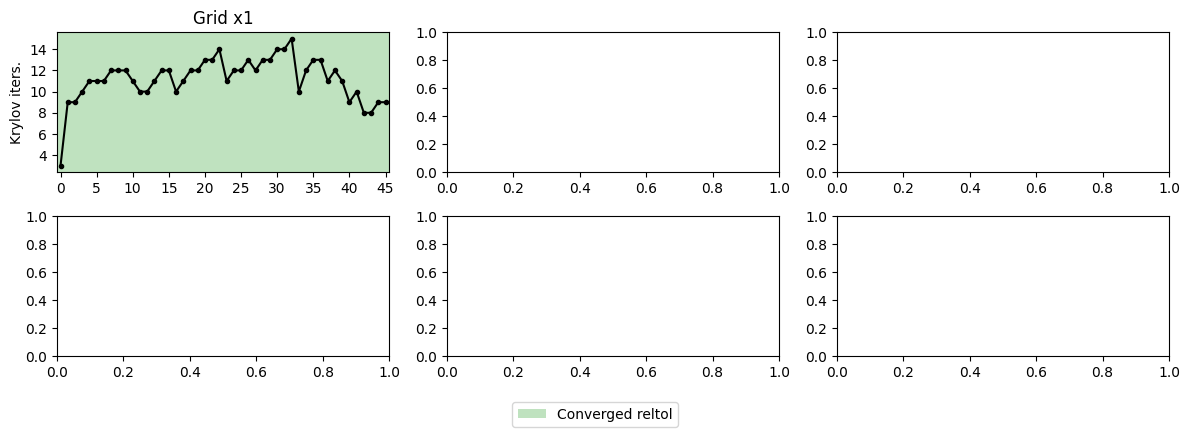

In [5]:
# grid_refinement = [1, 2, 3, 4, 5, 6, 10, 25, 30, 33, 35, 40]
grid_refinement = [1, 2, 5, 25, 33, 40]
grid_refinement = [1, ]

data = {}
names = {}
for i, g in enumerate(grid_refinement):
    data[i] = load_data(f"../stats/stats_geo0.2x{g}_sol{12}_ph{1}_bb{2}_fr{1}.json")
    names[i] = f"Grid x{g}"


shape = [2, 3]
figsize = (12, 4)


def render_element(entry: list[TimeStepStats]):
    color_converged_reason(entry)
    # color_sticking_sliding_open(entry)

    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    set_integer_ticks("vertical")
    plt.plot(get_gmres_iterations(entry), marker=".", color="black")


plot_grid(
    data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names
)

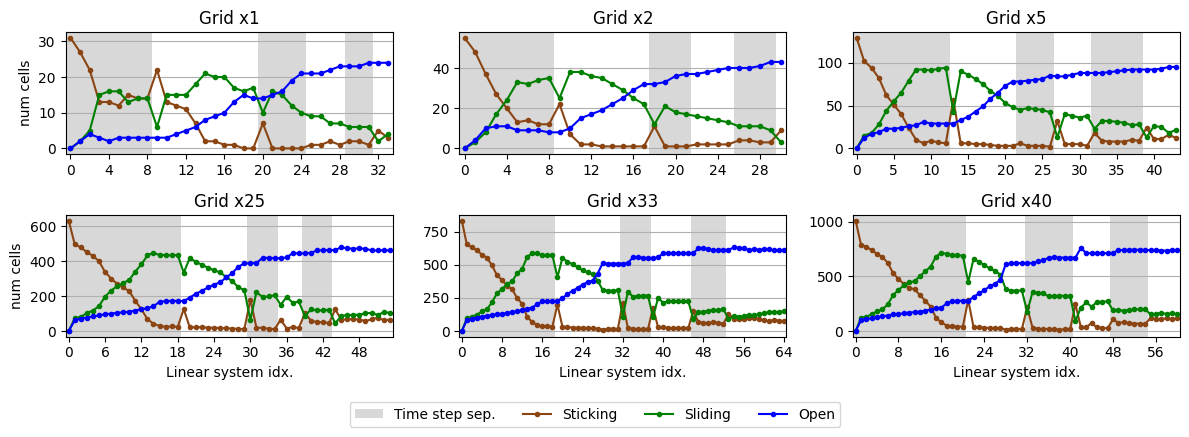

In [3]:
def render_element(i: int, entry: Sequence[TimeStepStats]):
    st, sl, op = get_num_sticking_sliding_open(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.gca().grid(False)
    plt.gca().grid(True, which="major", axis="y")
    plt.plot(st, label="Sticking", marker=".", color=COLOR_STICKING)
    plt.plot(sl, label="Sliding", marker=".", color=COLOR_SLIDING)
    plt.plot(op, label="Open", marker=".", color=COLOR_OPEN)
    # plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)


plot_grid(
    data,
    render_element,
    shape=shape,
    figsize=figsize,
    ylabel="num cells",
    ax_titles=names,
    #   ylabel="Fract. len., m"
)
# plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')

In [4]:
from collections import defaultdict
import pandas as pd

table = defaultdict(lambda: [])

NDIGITS = 2


for g in grid_refinement:
    stats_name = f"stats_geo0.2x{g}_sol2_ph1_bb2_fr1.json"
    entry = load_data(f"../stats/{stats_name}")
    dofs_info = load_data(f"../stats/dofs_info_{stats_name}")
    total_dofs = dofs_info["total dofs"]
    table["Total DoFs"].append(int(total_dofs))
    table["GMRES iters."].append(int(np.mean(get_gmres_iterations(entry))))
    table["Newton iters."].append(round(np.mean(get_newton_iterations(entry)), NDIGITS))

    converged_reason = get_petsc_converged_reason(entry)
    # table['\# lim iters.'].append(sum(np.array(get_petsc_converged_reason(entry)) < 0))

table = pd.DataFrame(table).T
table.rename(columns=table.iloc[0], inplace=True)
table = table[1:]
table.columns.name = "Total DoFs"
table

Total DoFs,1260.0,3714.0,19512.0,445608.0,769842.0,1126848.0
GMRES iters.,47.00,52.00,51.00,55.0,58.00,59.00
Newton iters.,5.67,5.17,7.33,9.0,10.83,10.17


In [35]:
[1, 2, 5, 25, 33, 40]

[1, 2, 5, 25, 33, 40]

In [5]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from mandel_runscript_2 import make_model
import porepy as pp


model = make_model(
    {
        "physics": 1,
        "geometry": 0.2,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 2,
        "solver": 2,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]



Sim time: 0.0, Dt: 0.01 (days)
sticking: 55, sliding: 0, open: 0


In [6]:
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    load_data(f"../stats/{model.simulation_name()}.json"), 7
)
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)

model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.ad_time_step.set_value(dt)
model.linear_system = mat, rhs
model.bmat.mat = mat


Sim time: 0.0, Dt: 0.01 (days)
sticking: 15, sliding: 32, open: 8


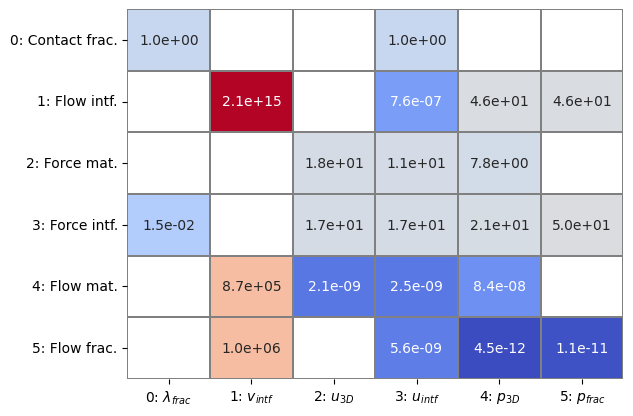

In [7]:
J = model.bmat[:]
J.plot_max()

AMG mech levels: 4
Construction took: 0.28
Solve  took: 0.15
True residual: 6.457585598290075e-09
PETSc Converged Reason: 2


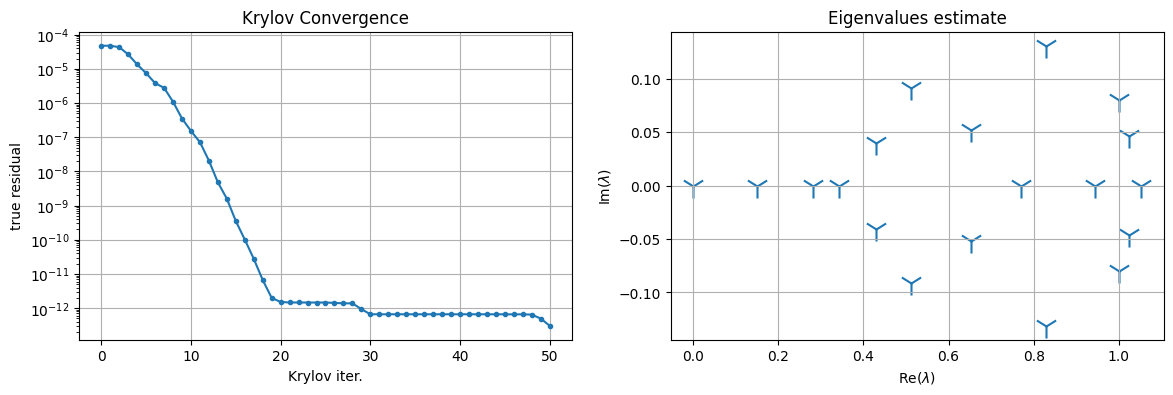

In [121]:
from fixed_stress import get_fixed_stress_stabilization, get_fs_fractures_analytical, make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

krylov = solve_petsc_3(
    J,
    rhs_global=rhs,
    return_data=True,
    ksp_scheme=KSPScheme(
        # ksp="richardson",
        rtol=1e-8,
        right_transformations=[
            lambda bmat: model.Qright(contact_group=0, u_intf_group=3)
        ],
        petsc_options={
            "ksp_type": "fgmres",
        },
        preconditioner=FieldSplitScheme(
            groups=[0],
            solve=lambda bmat: inv_block_diag(mat=bmat[[0]].mat, nd=model.nd),
            complement=FieldSplitScheme(
                groups=[1],
                solve=lambda bmat: PetscILU(bmat[[1]].mat, factor_levels=0),
                invertor=lambda bmat: extract_diag_inv(bmat[[1]].mat),
                complement=FieldSplitScheme(
                    groups=[2, 3],
                    solve=lambda bmat: PetscAMGMechanics(
                        mat=bmat[[2, 3]].mat,
                        dim=model.nd,
                        null_space=build_mechanics_near_null_space(model, include_intf=True),
                        petsc_options={
                            "mg_levels_ksp_type": "gmres",
                            "mg_levels_ksp_max_it": 10,
                            "mg_levels_ksp_gmres_restart": 10,
                            'pc_gamg_aggressive_coarsening': 0,
                        },
                    ),
                    # invertor='direct',
                    invertor_type="physical",
                    invertor=lambda bmat: make_fs_analytical(
                        model, bmat, p_mat_group=4, p_frac_group=5
                    ).mat,
                    # invertor=lambda bmat: get_fixed_stress_stabilization(model),
                    # invertor=lambda bmat: get_fs_fractures_analytical(model),
                    complement=FieldSplitScheme(
                        groups=[4, 5],
                        solve=lambda bmat: PetscAMGFlow(
                            mat=bmat[[4, 5]].mat, dim=model.nd
                        ),
                    ),
                ),
            ),
        ),
    ),
)

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


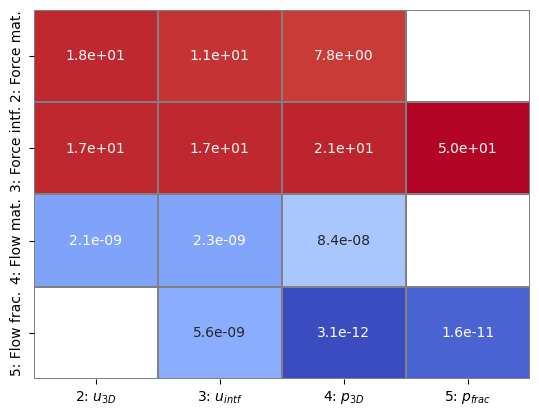

In [ ]:
from mat_utils import inv

Q = model.Qright(contact_group=0, u_intf_group=3)
JQ = J.copy()
JQ.mat = J.mat @ Q.mat
# k = [1,2,3,4,5]
k = [2, 3, 4, 5]
# k = [2,3]
e = [0]
S = JQ[k, k]
S.mat -= JQ[k, e].mat @ inv(JQ[e, e].mat) @ JQ[e, k].mat
S.plot_max()

AMG mech levels: 4
Construction took: 0.03
Solve  took: 0.05
True residual: 6.63535466980633e-05
PETSc Converged Reason: 3


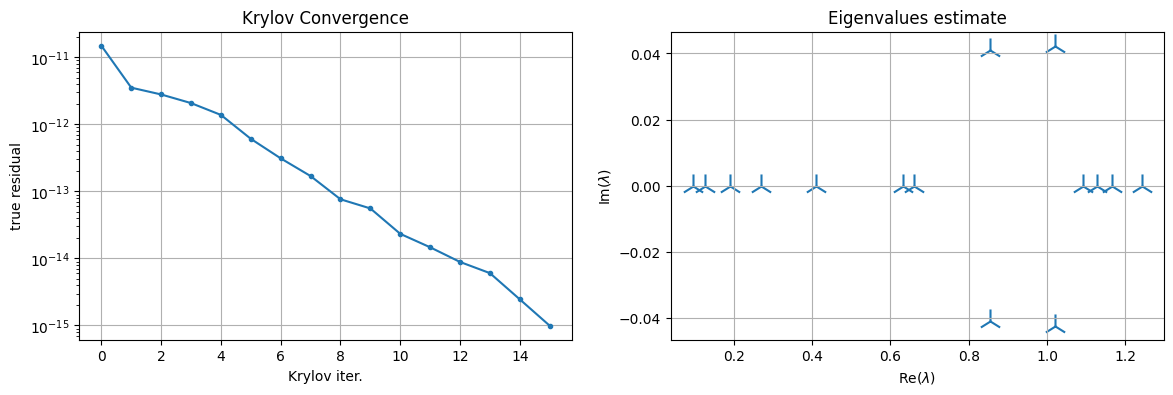

In [ ]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    S,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        petsc_options={"ksp_type": "fgmres"},
        preconditioner=FieldSplitScheme(
            groups=[2, 3],
            solve=lambda bmat: PetscAMGMechanics(
                mat=bmat[[2, 3]].mat,
                dim=model.nd,
                null_space=build_mechanics_near_null_space(model),
                petsc_options={
                    "mg_levels_ksp_type": "bcgs",
                    "mg_levels_ksp_max_it": 10,
                    "pc_gamg_aggressive_coarsening": 0,
                    "pc_gamg_threshold": 0.01,
                    "pc_gamg_agg_nsmooths": 1,
                },
            ),
        ),
    ),
)

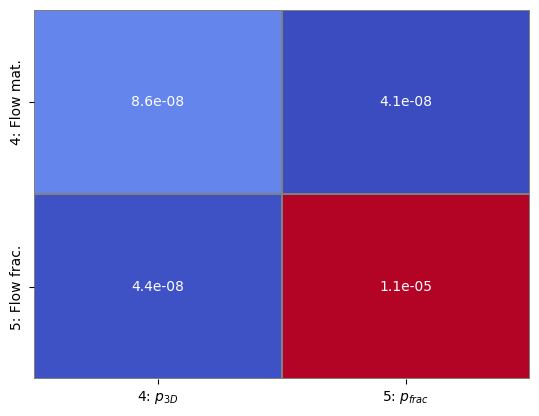

In [ ]:
k = [4, 5]
e = [2, 3]
S = J
S2 = S[k, k]
S2.mat -= S[k, e].mat @ inv(S[e, e].mat) @ S[e, k].mat
S2.plot_max()

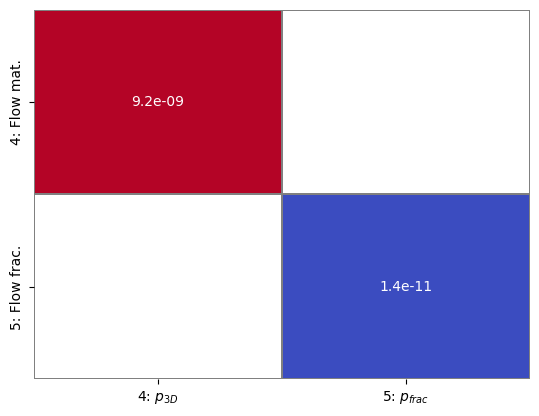

In [225]:
make_fs_analytical(model, S, p_mat_group=4, p_frac_group=5).plot_max()

AMG mech levels: 4
Construction took: 0.84
Solve  took: 0.52
True residual: 0.9597381931730451
PETSc Converged Reason: -3
lambda min: 2008.236191998177


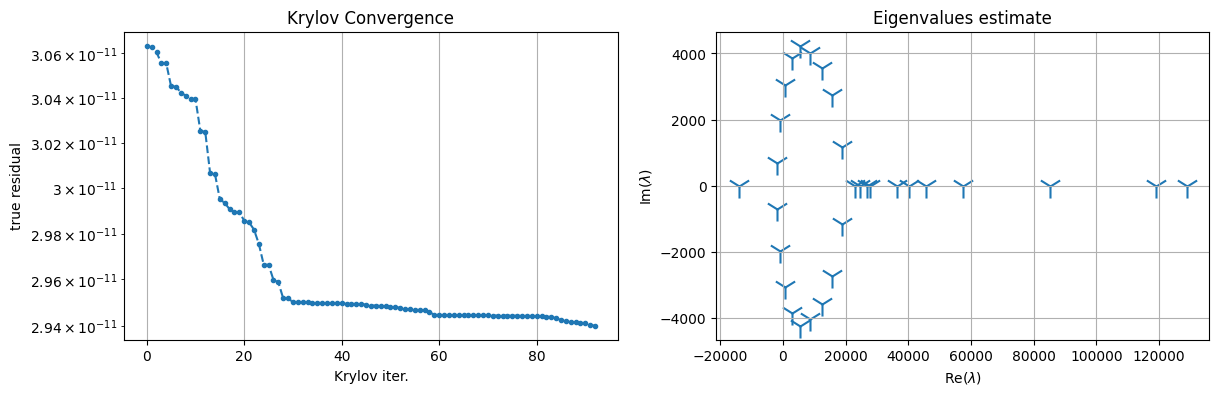

In [217]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    S,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        petsc_options={"ksp_type": "fgmres"},
        preconditioner=FieldSplitScheme(
            groups=[2, 3],
            solve=lambda bmat: PetscAMGMechanics(
                mat=bmat[[2, 3]].mat,
                dim=model.nd,
                null_space=build_mechanics_near_null_space(model),
                petsc_options={
                    "mg_levels_ksp_type": "bcgs",
                    "mg_levels_ksp_max_it": 10,
                    "pc_gamg_aggressive_coarsening": 0,
                    "pc_gamg_threshold": 0.01,
                    "pc_gamg_agg_nsmooths": 1,
                },
            ),
            # invertor='direct',
            invertor_type="physical",
            invertor=lambda bmat: make_fs_analytical(
                model, bmat, p_mat_group=4, p_frac_group=5
            ).mat,
            complement=FieldSplitScheme(
                groups=[4, 5],
                # solve=lambda bmat: PetscAMGFlow(mat=bmat[[4, 5]].mat, dim=model.nd),
            ),
        ),
    ),
)

AMG mech levels: 4
Construction took: 0.71
Solve  took: 3.79
True residual: 0.9905136724370511
PETSc Converged Reason: -3
lambda min: 0.8737091302815019


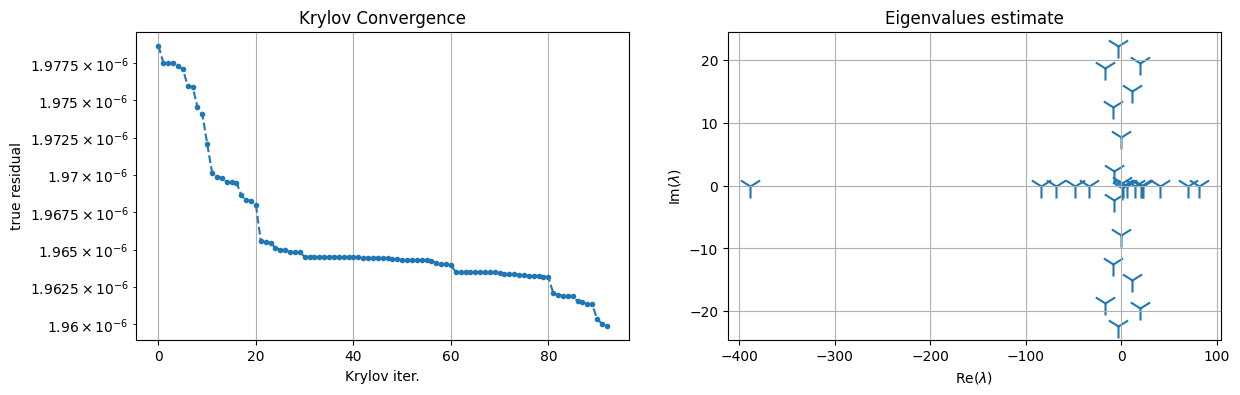

In [ ]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        # ksp="richardson",
        rtol=1e-8,
        right_transformations=[
            lambda bmat: model.Qright(contact_group=0, u_intf_group=3)
        ],
        petsc_options={"ksp_type": "fgmres"},
        preconditioner=FieldSplitScheme(
            groups=[0],
            solve=lambda bmat: inv_block_diag(mat=bmat[[0]].mat, nd=model.nd),
            complement=FieldSplitScheme(
                groups=[1],
                solve=lambda bmat: PetscILU(bmat[[1]].mat, factor_levels=0),
                invertor=lambda bmat: extract_diag_inv(bmat[[1]].mat),
                complement=FieldSplitScheme(
                    groups=[2, 3],
                    solve=lambda bmat: PetscAMGMechanics(
                        mat=bmat[[2, 3]].mat,
                        dim=model.nd,
                        null_space=build_mechanics_near_null_space(model),
                        petsc_options={
                            "mg_levels_ksp_type": "bcgs",
                            "mg_levels_ksp_max_it": 100,
                            "pc_gamg_aggressive_coarsening": 0,
                            "pc_gamg_threshold": 0.01,
                            "pc_gamg_agg_nsmooths": 1,
                        },
                    ),
                    # invertor='direct',
                    invertor_type="physical",
                    invertor=lambda bmat: make_fs_analytical(
                        model, bmat, p_mat_group=4, p_frac_group=5
                    ).mat,
                    complement=FieldSplitScheme(
                        groups=[4, 5],
                        solve=lambda bmat: PetscAMGFlow(
                            mat=bmat[[4, 5]].mat, dim=model.nd
                        ),
                    ),
                ),
            ),
        ),
    ),
)

AMG mech levels: 4
Construction took: 0.09
Solve  took: 0.05
True residual: 0.02290431453578918
PETSc Converged Reason: 2


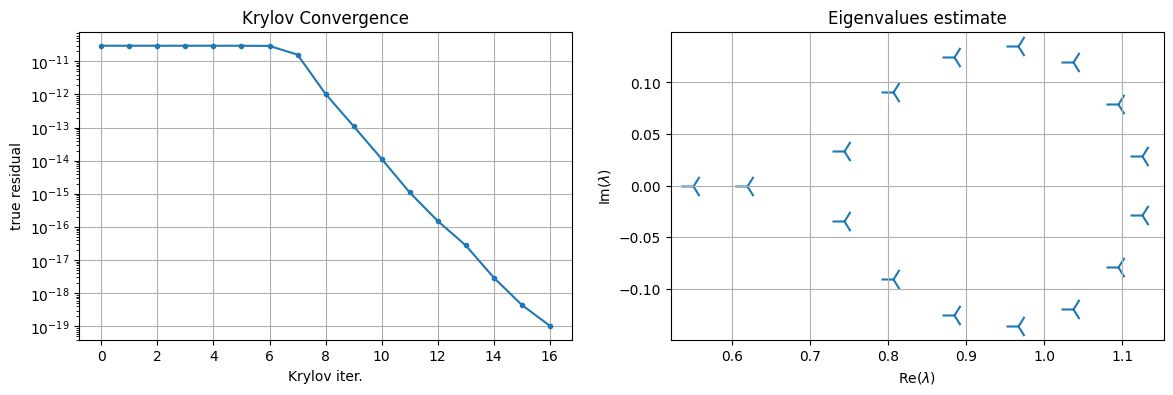

In [ ]:
from fixed_stress import (
    get_fixed_stress_stabilization,
    get_fs_fractures_analytical,
    make_fs_analytical,
)
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        # ksp="richardson",
        rtol=1e-8,
        atol=1e-30,
        petsc_options={"ksp_type": "fgmres"},
        preconditioner=FieldSplitScheme(
            groups=[2],
            solve=lambda bmat: PetscAMGMechanics(
                mat=bmat[[2]].mat,
                dim=model.nd,
                null_space=build_mechanics_near_null_space(model, include_intf=False),
                petsc_options={
                    "mg_levels_ksp_type": "bcgs",
                    "mg_levels_ksp_max_it": 10,
                    "pc_gamg_aggressive_coarsening": 0,
                    "pc_gamg_threshold": 0.01,
                },
            ),
            # invertor="direct",
            invertor_type="physical",
            invertor=lambda bmat: make_fs_analytical(
                model, bmat, p_mat_group=4, p_frac_group=5
            ).mat,
            # invertor=lambda bmat: get_fixed_stress_stabilization(model),
            # invertor=lambda bmat: get_fs_fractures_analytical(model),
            complement=FieldSplitScheme(
                groups=[4, 5],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[4, 5]].mat, dim=model.nd),
            ),
        ),
    ),
)

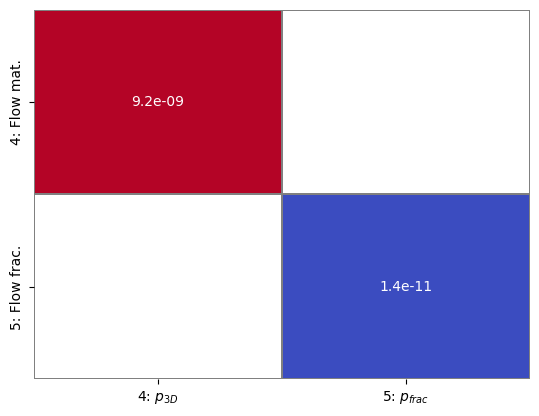

In [228]:
make_fs_analytical(model, J, p_mat_group=4, p_frac_group=5).plot_max()

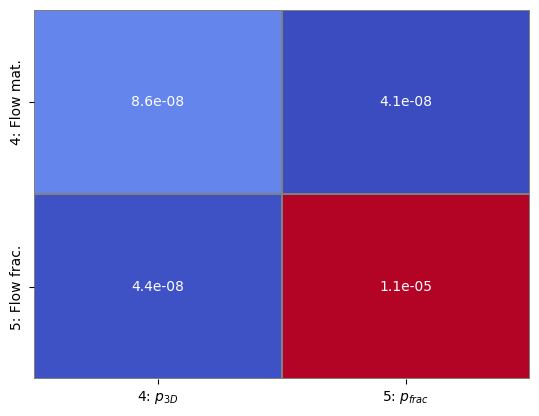

In [ ]:
k = [4, 5]
e = [2, 3]
S2 = J[k, k]
S2.mat -= J[k, e].mat @ inv(J[e, e].mat) @ J[e, k].mat
S2.plot_max()